# symmetric_quantile-normalized_score

## Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Initialize the ballot set dataframe
This can also be loaded in from a .csv file.

In [150]:
score_ballot_dictionary = {
    'ALICE': [27, 21, 25, 26, 17, 49, 65, 18, 45, 75, 9, 31],
    'BOB': [40, 40, 40, 50, 25, 60, 75, 2, 85, 95, 90, 75],
    'CHARLIE': [19, 21, 20, 50, 20, 65, 95, 3, 90, 85, 95, 10],
    'DENISE': [0, 0, 0, 0, 0, 100, 0, 0, 0, 90, 0, 0],
}

score_ballot_df = pd.DataFrame(score_ballot_dictionary).T
score_ballot_df

,0,1,2,3,4,5,6,7,8,9,10,11
STEPHEN,27,21,25,26,17,49,65,18,45,75,9,31
TRAVIS,40,40,40,50,25,60,75,2,85,95,90,75
CONNOR,19,21,20,50,20,65,95,3,90,85,95,10
ITALLIA,0,0,0,0,0,100,0,0,0,90,0,0


## Define auxiliary functions to linearly scale score ballots to span a pre-defined range.

Include a default case when a ballot has no variation.

In [151]:
def get_scaled_score_ballot(score_ballot, min=0, max=1):
    score_ballot = score_ballot
    max_score = np.max(score_ballot)
    min_score = np.min(score_ballot)

    score_range = max_score - min_score
    #print("score range: ", score_range)

    if score_range == 0:
        scaled_score_ballot = [1/2 for _ in score_ballot]
    else:
        scaled_score_ballot = [min+max*(score - min_score)/score_range for score in score_ballot]
    return scaled_score_ballot

def get_scaled_score_ballot_df(score_ballot_df, min=0, max=1):
    scaled_score_ballot_df = score_ballot_df.copy(deep=True)

    for index, score_ballot_row in score_ballot_df.iterrows():
        this_score_ballot = score_ballot_row.values
        #print(this_score_ballot)
        scaled_scores = get_scaled_score_ballot(this_score_ballot, min, max)
        scaled_score_ballot_df.loc[index] = scaled_scores  # Update the row in the DataFrame

    return scaled_score_ballot_df

#print(get_scaled_score_ballot([27, 21, 25, 26, 17, 49, 65, 18, 45, 75, 9, 31]))
#print(get_scaled_score_ballot(score_ballot_dictionary['STEPHEN']))
scaled_score_ballot_df = get_scaled_score_ballot_df(score_ballot_df)
scaled_score_ballot_df

,0,1,2,3,4,5,6,7,8,9,10,11
STEPHEN,0.272727,0.181818,0.242424,0.257576,0.121212,0.606061,0.848485,0.136364,0.545455,1.000000,0.000000,0.333333
TRAVIS,0.408602,0.408602,0.408602,0.516129,0.247312,0.623656,0.784946,0.000000,0.892473,1.000000,0.946237,0.784946
CONNOR,0.173913,0.195652,0.184783,0.510870,0.184783,0.673913,1.000000,0.000000,0.945652,0.891304,1.000000,0.076087
ITALLIA,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.900000,0.000000,0.000000


## Define a function to compute the asymmetric quantile normalized score values.

In [168]:
def get_quantile_normalized_values(score_ballot_df):
    # Sort the values in each column
    score_ballot_df = score_ballot_df.T
    sorted_df = np.sort(score_ballot_df, axis=0)
    
    # Calculate the mean of each row across the sorted columns
    mean_values = np.mean(sorted_df, axis=1)
    
    # Rank the values in the original dataframe
    ranks = score_ballot_df.stack().groupby(score_ballot_df.rank(method='min').stack().astype(int)).mean()
    
    # Replace ranks with mean values
    #normalized_df = score_ballot_df.rank(method='min').stack().astype(int).map(ranks).unstack()
    #print(list(mean_values))
    return list(mean_values)

get_quantile_normalized_values(scaled_score_ballot_df)


[0.0,
 0.1111527264227124,
 0.1797197075948829,
 0.19380073526286712,
 0.20895225041438226,
 0.24233924093671638,
 0.35181318798078964,
 0.44804815334268344,
 0.555426282459943,
 0.6110464745633049,
 0.9236803519061584,
 1.0]

## Simply combine the linear scaling to compute asymmetric quantile normalized values over scaled ballots.

In [218]:

def get_quantile_normalized_scaled_values(score_ballot_df, min=0, max=1):
    scaled_score_ballot_df = get_scaled_score_ballot_df(score_ballot_df, min, max)
    return np.array(get_quantile_normalized_values(scaled_score_ballot_df))

get_quantile_normalized_scaled_values(score_ballot_df)


array([0.        , 0.11115273, 0.17971971, 0.19380074, 0.20895225,
       0.24233924, 0.35181319, 0.44804815, 0.55542628, 0.61104647,
       0.92368035, 1.        ])

## Define a simple function to transform the asymmetric quantile normalized values into a symmetric version that preserves cancellation properties.

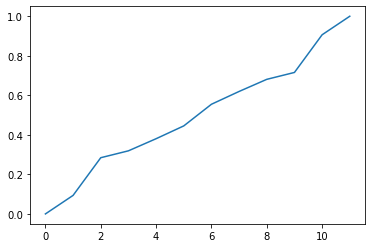

In [219]:
def get_symmetric_scaled_quantile_normalized_values(score_ballot_df, min=0, max=1):
    scaled_quantile_normalized_values = get_quantile_normalized_scaled_values(score_ballot_df, min, max)

    num_values = len(scaled_quantile_normalized_values)

    symmetric_scaled_quantile_normalized_values = [(scaled_quantile_normalized_values[k] + (max-scaled_quantile_normalized_values[(num_values -1) - k]))/2 for k in range(num_values)]

    return symmetric_scaled_quantile_normalized_values

plt.plot(get_symmetric_scaled_quantile_normalized_values(score_ballot_df))

## Modify ordinary quantile normalization by replacing asymmetric quantile values with their symmetrical adjusted values.

Adjustments are also made to account for repeated values. When values are tied in rank, they are assigned the mean of the values corresponding to the ranks they would normally represent if they were different. This still preserves symmetry and hence the desired cancellation properties.

In [230]:
def get_symmetric_scaled_quantile_normalized_score_ballot_df(score_ballot_df, min=0, max=1):
    #print(score_ballot_df)
    # Rank the values in each column
    symmetric_scaled_quantile_normalized_score_values = get_symmetric_scaled_quantile_normalized_values(score_ballot_df, min, max)
    #print((symmetric_scaled_quantile_normalized_score_values))
    #print('\n')

    #print("\nOriginal score ballots:\n", score_ballot_df)

    score_rankings_df = score_ballot_df.rank(axis=1, method='first').astype(int) -1
    #print("\nScore ranking ballots:\n ", score_rankings_df)
    #print('\n')
    #print(score_ballot_df)

    as_if_unique_normalized_df = score_rankings_df.applymap(lambda x: symmetric_scaled_quantile_normalized_score_values[x])
    #print("\nNormalized as if scores are unique:\n ", as_if_unique_normalized_df)

    corrected_df = as_if_unique_normalized_df.copy()

    for index, row in score_ballot_df.iterrows():
        # Get the scores and their corresponding ranks from the original dataframe
        scores_with_ranks = row.rank(method='first').astype(int) - 1
        unique_scores = row.unique()
        
        for score in unique_scores:
            # Find the ranks (indices) associated with this score
            ranks_for_score = scores_with_ranks[row == score].values
            # Calculate the average of the symmetric scaled values for these ranks
            avg_value = as_if_unique_normalized_df.loc[index, ranks_for_score].mean()
            # Assign this average back to the corresponding locations in the corrected dataframe
            corrected_df.loc[index, ranks_for_score] = avg_value

    return corrected_df

symmetric_scaled_quantile_normalized_score_ballot_df=get_symmetric_scaled_quantile_normalized_score_ballot_df(score_ballot_df)
symmetric_scaled_quantile_normalized_score_ballot_df

,0,1,2,3,4,5,6,7,8,9,10,11
STEPHEN,0.554737,0.319187,0.380452,0.445263,0.093736,0.715663,0.906264,0.284337,0.680813,1.000000,0.000000,0.619548
TRAVIS,0.284337,0.319187,0.306484,0.306484,0.306484,0.554737,0.619548,0.357832,0.357832,1.000000,0.906264,0.680813
CONNOR,0.284337,0.445263,0.319187,0.467595,0.467595,0.619548,0.906264,0.000000,0.715663,0.680813,0.546868,0.546868
ITALLIA,0.460352,0.460352,0.460352,0.460352,0.460352,0.460352,0.460352,0.460352,0.460352,0.460352,0.680813,0.715663


## Observe the election results by tallying symmetric quantile-normalized score values for each candidate.

Here an average is computed.

Text(0.5, 1.0, 'Normalized Candidate Scores')

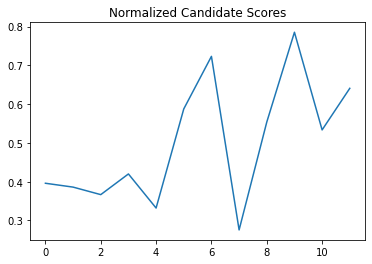

In [240]:
column_averages = symmetric_scaled_quantile_normalized_score_ballot_df.mean(axis=0)
column_averages
plt.plot(column_averages)
plt.title('Normalized Candidate Scores')